In [1]:
import os, h5py
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from tqdm import tqdm
import copy, math
import collections

from cremerl import utils, model_zoo, shuffle

import shuffle_test

#import gymnasium as gym

import logging

# Set the logging level to WARNING
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [2]:
expt_name = 'DeepSTARR'

# load data
data_path = '../../data/'
filepath = os.path.join(data_path, expt_name+'_data.h5')
data_module = utils.H5DataModule(filepath, batch_size=100, lower_case=False, transpose=False)


In [3]:
deepstarr2 = model_zoo.deepstarr(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr2, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = model_zoo.DeepSTARR(deepstarr2,
                                  criterion=loss,
                                  optimizer=optimizer_dict)

# load checkpoint for model with best validation performance
standard_cnn = utils.load_model_from_checkpoint(standard_cnn, 'DeepSTARR_standard.ckpt')

# evaluate best model
pred = utils.get_predictions(standard_cnn, data_module.x_test[np.newaxis,100], batch_size=100)

/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
2023-08-14 16:50:58.362075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 16:50:58.975905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Predicting: 0it [00:00, ?it/s]

In [4]:
def get_swap_greedy(x, x_mut, tile_ranges):
    ori = x.copy()
    mut = x_mut.copy()
    for tile_range in tile_ranges:
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]

    return ori, mut

def get_score(pred):
    score1 = pred[0] - pred[2]
    score2 = pred[3] - pred[1]
    return (score1+score2)[0], score1+score2

def generate_tile_ranges(sequence_length, window_size, stride):
    ranges = []
    start = np.arange(0, sequence_length - window_size + stride, stride)

    for s in start:
        e = min(s + window_size, sequence_length)
        ranges.append([s, e])

    if start[-1] + window_size - stride < sequence_length:  # Adjust the last range
        ranges[-1][1] = sequence_length

    return ranges

In [5]:
def get_batch(x, tile_range, tile_ranges_ori, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = shuffle.dinuc_shuffle(x.copy())
        test_batch.append(x_mut)

        ori = x.copy()
        mut = x_mut.copy()
        
        ori, mut = get_swap_greedy(ori, mut, tile_ranges_ori)
        
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]
        
        test_batch.append(ori)
        test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)


def get_batch_score(pred, trials):

    score = []
    score_sep = []
    for i in range(0, pred.shape[0], 2):
        # print(f"Viewing number {i}")
        score1 = pred[0] - pred[i]
        score2 = pred[i+1] - pred[1]
        score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
        score_sep.append((score1+score2).tolist())
        
    # print(score)
        
    final = np.sum(np.array(score), axis=0)/trials

    #max_ind = np.argmax(final)
    #block_ind = np.argmax(np.array(score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])
    total_score_sep = np.sum(np.array(score_sep), axis=0)/trials

    #print(np.max(score))
    return final

In [6]:
def extend_sequence(one_hot_sequence):
    A, L = one_hot_sequence.shape

    # Create an all-ones row
    ones_row = np.zeros(L)

    # Add the all-ones row to the original sequence
    new_sequence = np.vstack((one_hot_sequence, ones_row))

    return np.array(new_sequence, dtype='float32')

def taking_action(sequence_with_ones, tile_range):
    start_idx, end_idx = tile_range

    # Ensure the start_idx and end_idx are within valid bounds
    #if start_idx < 0 or start_idx >= sequence_with_ones.shape[1] or end_idx < 0 or end_idx >= sequence_with_ones.shape[1]:
    #    raise ValueError("Invalid tile range indices.")

    # Copy the input sequence to avoid modifying the original sequence
    modified_sequence = sequence_with_ones.copy()

    # Modify the last row within the specified tile range
    modified_sequence[-1, start_idx:end_idx] = 1

    return np.array(modified_sequence, dtype='float32')

In [7]:
def convert_elements(input_list):
    input_list = input_list.tolist()
    num_columns = 5  # Number of elements to process in each group

    # Calculate the number of elements needed to pad the list
    padding_length = num_columns - (len(input_list) % num_columns)
    last_value = input_list[-1]
    padded_list = input_list + [last_value] * padding_length

    # Convert the padded list to a NumPy array for efficient operations
    input_array = np.array(padded_list)
    reshaped_array = input_array.reshape(-1, num_columns)

    # Check if each row has the same value (all 0s or all 1s)
    row_all_zeros = np.all(reshaped_array == 0, axis=1)
    row_all_ones = np.all(reshaped_array == 1, axis=1)

    # Replace all 0s with 0 and all 1s with 1 in the result array
    output_array = np.where(row_all_zeros, 0, np.where(row_all_ones, 1, reshaped_array[:, 0]))

    # Flatten the result array to get the final output list
    output_list = output_array.flatten()

    return output_list

In [8]:
class SeqGame:
    def __init__(self, sequence, model_func):
        self.seq = sequence
        self.ori_seq = sequence.copy()
        self.tile_ranges = generate_tile_ranges(sequence.shape[1], 5, 5)
        self.levels = 20
        self.num_trials = 10
        self.action_size = 50
        
        self.prev_score = -float("inf")
        self.current_score = 0
        
        self.trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
        self.model = model_func
        
        if self.seq.shape[0]!=5:
            self.seq = extend_sequence(self.seq)
            self.ori_seq = extend_sequence(self.ori_seq)
        
    
    def get_initial_state(self):
        self.seq = self.ori_seq.copy()
        
        return self.seq
    
    
    def get_next_state(self, action, tile_ranges_done):
        self.prev_score = self.current_score
        # self.current_level += 1
        
        self.seq = taking_action(self.seq, self.tile_ranges[action])
        
        batch = get_batch(self.seq[:4, :], self.tile_ranges[action], tile_ranges_done, self.num_trials)
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred = np.concatenate(self.trainer.predict(self.model, dataloaders=dataloader))
        
        self.current_score = np.tanh(1 * get_batch_score(pred, self.num_trials)) #ADDED TANH
        
        return self.seq
    
    def get_valid_moves(self):
        return (convert_elements(self.seq[-1, :]) == 0).astype(np.uint8)
    
    def terminate(self, level, current_score, parent_score): #state
        # if self.current_level >= self.levels:
        #     return True
        # if self.current_score < self.prev_score:
        #     return True
        
        if level >= self.levels:
            return True
        if current_score < parent_score:
            return True
    
        return False
    
    def set_seq(self, seq):
        self.seq = seq
    
    def get_seq(self):
        return self.seq.copy()
    
    def get_score(self):
        return self.current_score

In [9]:
class Node:
    def __init__(self, action, state, done, reward, mcts, level, tile_ranges_done, parent=None):
        self.env = parent.env
        self.action = action
        
        self.is_expanded = False
        self.parent = parent
        self.children = {}
        
        self.action_space_size = self.env.action_size
        self.child_total_value = np.zeros(
            [self.action_space_size], dtype=np.float32
        ) # Q
        self.child_priors = np.zeros([self.action_space_size], dtype=np.float32) # P
        self.child_number_visits = np.zeros(
            [self.action_space_size], dtype=np.float32
        ) # N
        self.valid_actions = (convert_elements(state[-1, :]) == 0).astype(np.uint8)
        
        self.reward = reward
        self.done = done
        self.state = state
        self.level = level
        
        self.tile_ranges_done = tile_ranges_done
        
        self.mcts = mcts
    
    @property
    def number_visits(self):
        return self.parent.child_number_visits[self.action]
    
    @number_visits.setter
    def number_visits(self, value):
        self.parent.child_number_visits[self.action] = value
        
    @property
    def total_value(self):
        return self.parent.child_total_value[self.action]
    
    @total_value.setter
    def total_value(self, value):
        self.parent.child_total_value[self.action] = value
        
    def child_Q(self):
        return self.child_total_value / (1 + self.child_number_visits)
    
    def child_U(self):
        return (
            math.sqrt(self.number_visits)
            * self.child_priors
            / (1 + self.child_number_visits)
        )
    
    def best_action(self):
        child_score = self.child_Q() + self.mcts.c_puct * self.child_U()
        masked_child_score = child_score
        # masked_child_score[~self.valid_actions] = -np.inf
        masked_child_score = masked_child_score * self.valid_actions
        return np.argmax(masked_child_score)
    
    def select(self):
        current_node = self
        while current_node.is_expanded:
            best_action = current_node.best_action()
            current_node = current_node.get_child(best_action)
        return current_node
    
    def expand(self, child_priors):
        self.is_expanded = True
        self.child_priors = child_priors
        
    def set_state(self, state):
        self.state = state
        self.valid_actions = (convert_elements(state[-1, :]) == 0).astype(np.uint8)
    
    def get_child(self, action):
        if action not in self.children:

            self.env.set_seq(self.state.copy())
            next_state = self.env.get_next_state(action, self.tile_ranges_done)
            # self.tile_ranges_done.append(self.tile_ranges.pop(action))
            new_tile_ranges_done = copy.deepcopy(self.tile_ranges_done)
            # print(new_tile_ranges_done)
            new_tile_ranges_done.append(self.env.tile_ranges[action])
            # swap tile_ranges
            reward = self.env.get_score()
            terminated = self.env.terminate(self.level, reward, self.parent.reward)
            self.children[action] = Node(
                state=next_state, 
                action=action, 
                parent=self, 
                reward=reward,
                done=terminated,
                mcts=self.mcts, 
                level=self.level+1, 
                tile_ranges_done=new_tile_ranges_done
            )
        return self.children[action]
    
    def backup(self, value):
        current = self
        while current.parent is not None:
            current.number_visits += 1
            current.total_value += value
            current = current.parent

class RootParentNode:
    def __init__(self, env):
        self.parent = None
        self.child_total_value = collections.defaultdict(float)
        self.child_number_visits = collections.defaultdict(float)
        self.env = env
        self.reward = -np.inf

class MCTS:
    def __init__(self, model, mcts_param):
        self.model = model
        self.temperature = mcts_param["temperature"]
        self.dir_epsilon = mcts_param["dirichlet_epsilon"]
        self.dir_noise = mcts_param["dirichlet_noise"]
        self.num_sims = mcts_param["num_simulations"]
        self.exploit = mcts_param["argmax_tree_policy"]
        self.add_dirichlet_noise = mcts_param["add_dirichlet_noise"]
        self.c_puct = mcts_param["puct_coefficient"]
    
    def compute_action(self, node):
        for _ in range(self.num_sims):
            leaf = node.select()
            if leaf.done:
                value = leaf.reward
            else:
                child_priors, value = self.model(torch.tensor(leaf.state).unsqueeze(0))
                child_priors = torch.softmax(child_priors, axis=1).squeeze(0).cpu().detach().numpy()
                if self.add_dirichlet_noise:
                    child_priors = (1 - self.dir_epsilon) * child_priors
                    child_priors += self.dir_epsilon * np.random.dirichlet(
                        [self.dir_noise] * child_priors.size
                    )
                
                leaf.expand(child_priors)
            leaf.backup(value)
            
        tree_policy = node.child_number_visits / node.number_visits
        tree_policy = tree_policy / np.max(tree_policy)
        tree_policy = np.power(tree_policy, self.temperature)
        tree_policy = tree_policy / np.sum(tree_policy)
        if self.exploit:
            action = np.argmax(tree_policy)
        else:
            action = np.random.choice(np.arange(node.action_space_size), p=tree_policy)
        return tree_policy, action, node.children[action]

In [10]:
class CNN_v0(nn.Module):
    def __init__(self, action_dim):
        super(CNN_v0, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32), 
            nn.ReLU()
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64), 
            nn.ReLU()
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), 
            nn.ReLU()
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, action_dim) # 4 * action_dim
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, 128), 
            nn.Linear(128, 1), 
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

In [ ]:
sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)


mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 10000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

model = CNN_v0(seqgame.action_size)
model.eval()

mcts = MCTS(model, mcts_config)

# Get the initial sequence and create the root node
initial_sequence = seqgame.get_seq()
    
root_node = Node(
    state=initial_sequence,
    reward=0,
    done=False,
    action=None,
    parent=RootParentNode(env=seqgame),
    mcts=mcts, 
    level=0, 
    tile_ranges_done=[]
)

while not root_node.done:  # Loop until the root node indicates the game is done
    print("Current sequence:", convert_elements(root_node.state[-1,:]))
    valid_moves = root_node.valid_actions
    print("Valid moves:", [i for i in range(seqgame.action_size) if valid_moves[i] == 1])

    # Perform simulations and select an action using MCTS
    mcts_probs, action, next_node = mcts.compute_action(root_node)
    print("MCTS probabilities:", mcts_probs)
    print("Selected action:", action)
    

    if valid_moves[action] == 0:
        print("Invalid action, skipping.")
        continue
    
    print(root_node.tile_ranges_done)
    print(root_node.reward)

    root_node = next_node

print("Game ended.")


In [11]:
class AlphaDNA:
    def __init__(self, model, optimizer, env, args, mcts_config = {
        "puct_coefficient": 2.0,
        "num_simulations": 10000,
        "temperature": 1.5,
        "dirichlet_epsilon": 0.25,
        "dirichlet_noise": 0.03,
        "argmax_tree_policy": False,
        "add_dirichlet_noise": True,}
                 ):
        self.model = model
        self.optimizer = optimizer
        self.env = env
        self.args = args
        self.mcts = MCTS(model, mcts_config)
        
        self.initial_sequence = env.get_seq()
    
    def selfPlay(self):
        memory = []

        root_node = Node(
            state=self.initial_sequence,
            reward=0,
            done=False,
            action=None,
            parent=RootParentNode(env=seqgame),
            mcts=self.mcts, 
            level=0, 
            tile_ranges_done=[]
        )

        while True:  # Loop until the root node indicates the game is done
            valid_moves = root_node.valid_actions
            mcts_probs, action, next_node = self.mcts.compute_action(root_node)
            
            memory.append((root_node.state, mcts_probs, next_node.reward))

            if valid_moves[action] == 0:
                print("Invalid action, skipping.")
                continue
            
            if next_node.done:
                return memory

            root_node = next_node
    
    def train(self, memory):
        np.random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets)
            
            state = torch.tensor(state, dtype=torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
            value_targets = torch.tensor(value_targets, dtype=torch.float32)
            
            out_policy, out_value = self.model(state)
            
            priors = nn.Softmax(dim=-1)(out_policy)
            
            policy_loss = torch.mean(
                -torch.sum(policy_targets * torch.log(priors), dim=-1)
            )
            value_loss = torch.mean(torch.pow(value_targets - out_value, 2))
            
            total_loss = policy_loss + value_loss
            
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            
            return total_loss
        
    def learn(self):
        lowest_loss = np.inf
        for iteration in tqdm(range(self.args['num_iterations'])):
            print(f"Iteration {iteration}:")
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in tqdm(range(self.args['num_selfPlay_iterations'])):
                print(f"SelfPlay Iteration {selfPlay_iteration}")
                memory += self.selfPlay()
            
            self.model.train()
            for epoch in tqdm(range(self.args['num_epochs'])):
                print(f"Training Epoch {epoch}")
                loss = self.train(memory)
                print(f"Total Loss: {loss}")
                
                if loss < lowest_loss:
                    print("Saving the best model")
                    lowest_loss = loss
                    torch.save(self.model.state_dict(), "best_model.pt")
                    torch.save(self.optimizer.state_dict(), "best_optimizer.pt")
                
            
            

In [12]:
sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)

model = CNN_v0(seqgame.action_size)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'num_iterations': 20, # 3 
    'num_selfPlay_iterations': 2, # 500
    'num_epochs': 4, 
    'batch_size': 2, # 64
}

mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 1000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

alphadna = AlphaDNA(model, optimizer, seqgame, args, mcts_config)
alphadna.learn()

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 0:


SelfPlay Iteration 0


SelfPlay Iteration 1


  5%|▌         | 1/20 [00:11<03:34, 11.29s/it]

Training Epoch 0
Total Loss: 4.756659507751465
Saving the best model
Training Epoch 1
Total Loss: 23.226892471313477
Training Epoch 2
Total Loss: 29.217710494995117
Training Epoch 3
Total Loss: 2.910061836242676
Saving the best model
Iteration 1:


SelfPlay Iteration 0


SelfPlay Iteration 1


 10%|█         | 2/20 [00:40<06:37, 22.10s/it]

Training Epoch 0
Total Loss: 30.931066513061523
Training Epoch 1
Total Loss: 11.025620460510254
Training Epoch 2
Total Loss: 23.65279769897461
Training Epoch 3
Total Loss: 15.953851699829102
Iteration 2:


SelfPlay Iteration 0


SelfPlay Iteration 1


 15%|█▌        | 3/20 [01:31<09:53, 34.90s/it]

Training Epoch 0
Total Loss: 15.782939910888672
Training Epoch 1
Total Loss: 24.044506072998047
Training Epoch 2
Total Loss: 13.096134185791016
Training Epoch 3
Total Loss: 8.670369148254395
Iteration 3:


SelfPlay Iteration 0


SelfPlay Iteration 1


 20%|██        | 4/20 [02:00<08:45, 32.87s/it]

Training Epoch 0
Total Loss: 10.551641464233398
Training Epoch 1
Total Loss: 7.007012844085693
Training Epoch 2
Total Loss: 4.480101585388184
Training Epoch 3
Total Loss: 13.354626655578613
Iteration 4:


SelfPlay Iteration 0


SelfPlay Iteration 1


 25%|██▌       | 5/20 [02:21<07:08, 28.54s/it]

Training Epoch 0
Total Loss: 6.544302940368652
Training Epoch 1
Total Loss: 2.9155566692352295
Training Epoch 2
Total Loss: 8.83521556854248
Training Epoch 3
Total Loss: 3.5410900115966797
Iteration 5:


SelfPlay Iteration 0


SelfPlay Iteration 1


 30%|███       | 6/20 [02:49<06:37, 28.39s/it]

Training Epoch 0
Total Loss: 5.355292320251465
Training Epoch 1
Total Loss: 7.026004314422607
Training Epoch 2
Total Loss: 6.285071849822998
Training Epoch 3
Total Loss: 5.9423909187316895
Iteration 6:


SelfPlay Iteration 0


SelfPlay Iteration 1


 35%|███▌      | 7/20 [03:11<05:41, 26.29s/it]

Training Epoch 0
Total Loss: 7.398082733154297
Training Epoch 1
Total Loss: 8.668726921081543
Training Epoch 2
Total Loss: 5.050792217254639
Training Epoch 3
Total Loss: 3.540869951248169
Iteration 7:


SelfPlay Iteration 0


SelfPlay Iteration 1


 40%|████      | 8/20 [03:46<05:48, 29.03s/it]

Training Epoch 0
Total Loss: 3.7958462238311768
Training Epoch 1
Total Loss: 1.939974069595337
Saving the best model
Training Epoch 2
Total Loss: 4.334042549133301
Training Epoch 3
Total Loss: 5.36262321472168
Iteration 8:


SelfPlay Iteration 0


SelfPlay Iteration 1


 45%|████▌     | 9/20 [04:22<05:43, 31.22s/it]

Training Epoch 0
Total Loss: 3.2128818035125732
Training Epoch 1
Total Loss: 3.0261423587799072
Training Epoch 2
Total Loss: 4.813085556030273
Training Epoch 3
Total Loss: 3.4427661895751953
Iteration 9:


SelfPlay Iteration 0


SelfPlay Iteration 1


 50%|█████     | 10/20 [04:41<04:33, 27.40s/it]

Training Epoch 0
Total Loss: 7.917288303375244
Training Epoch 1
Total Loss: 6.972733974456787
Training Epoch 2
Total Loss: 2.9865565299987793
Training Epoch 3
Total Loss: 4.699330806732178
Iteration 10:


SelfPlay Iteration 0


SelfPlay Iteration 1


 55%|█████▌    | 11/20 [04:56<03:32, 23.66s/it]

Training Epoch 0
Total Loss: 1.4707512855529785
Saving the best model
Training Epoch 1
Total Loss: 1.0331815481185913
Saving the best model
Training Epoch 2
Total Loss: 2.694047451019287
Training Epoch 3
Total Loss: 1.2465119361877441
Iteration 11:


SelfPlay Iteration 0


SelfPlay Iteration 1


 55%|█████▌    | 11/20 [05:06<04:10, 27.87s/it]


KeyboardInterrupt: 

In [139]:
sequence = data_module.x_test[2].numpy()
seqgame = SeqGame(sequence, standard_cnn)


mcts_config = {
    "puct_coefficient": 2.0,
    "num_simulations": 10000,
    "temperature": 1.5,
    "dirichlet_epsilon": 0.25,
    "dirichlet_noise": 0.03,
    "argmax_tree_policy": False,
    "add_dirichlet_noise": True,
}

model = CNN_v0(seqgame.action_size)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

mcts = MCTS(model, mcts_config)

# Get the initial sequence and create the root node
initial_sequence = seqgame.get_seq()
    
root_node = Node(
    state=initial_sequence,
    reward=0,
    done=False,
    action=None,
    parent=RootParentNode(env=seqgame),
    mcts=mcts, 
    level=0, 
    tile_ranges_done=[]
)

while not root_node.done:  # Loop until the root node indicates the game is done
    print("Current sequence:", convert_elements(root_node.state[-1,:]))
    valid_moves = root_node.valid_actions
    print("Valid moves:", [i for i in range(seqgame.action_size) if valid_moves[i] == 1])

    # Perform simulations and select an action using MCTS
    mcts_probs, action, next_node = mcts.compute_action(root_node)
    print("MCTS probabilities:", mcts_probs)
    print("Selected action:", action)
    

    if valid_moves[action] == 0:
        print("Invalid action, skipping.")
        continue
    
    print(root_node.tile_ranges_done)
    print(root_node.reward)

    root_node = next_node

print("Game ended.")


Current sequence: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Valid moves: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
MCTS probabilities: [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.8947314e-05 1.1986699e-05
 5.5709138e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.5709138e-06 6.8615860e-05 0.0000000e+00
 3.0324213e-06 8.5769825e-06 5.5709138e-06 0.0000000e+00 5.5709138e-06
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0324213e-06 9.9272728e-01
 0.0000000e+00 1.1986699e-05 8.8792236e-05 3.9114122e-05 4.4567310e-05
 6.5737288e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.2284715e-05
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0324213e-06 0.0000000e+00
 2.8146233e-04 0.0000000e+00 0.00000

In [113]:
def get_batch(x, tile_ranges_new, tile_ranges_ori, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = shuffle.dinuc_shuffle(x.copy())
        test_batch.append(x_mut)

        for tile_range in tile_ranges_new:
            ori = x.copy()
            mut = x_mut.copy()
            
            ori, mut = get_swap_greedy(ori, mut, tile_ranges_ori)
            
            ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
            mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]
            
            test_batch.append(ori)
            test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)

def find_max(pred, trials):
    b_size = int(pred.shape[0]/trials)
    loop_range = generate_tile_ranges(pred.shape[0], b_size, b_size)
    total_score = []
    total_score_sep = []
    for rang in loop_range:
        score = []
        score_sep = []
        p_pred = pred[rang[0]:rang[1]]
        for i in range(0, p_pred.shape[0]-2, 2):
            score1 = p_pred[0] - p_pred[i]
            score2 = p_pred[i+1] - p_pred[1]
            score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
            score_sep.append((score1+score2).tolist())

        #print(score)

        total_score.append(score)
        total_score_sep.append(score_sep)

    final = np.sum(np.array(total_score), axis=0)/trials

    max_ind = np.argmax(final)
    block_ind = np.argmax(np.array(total_score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])

    total_score = final
    total_score_sep = np.sum(np.array(total_score_sep), axis=0)/trials


    #print(np.max(score))
    return total_score_sep, np.max(total_score), np.argmax(total_score), block_ind


def get_swap_greedy(x, x_mut, tile_ranges):
    ori = x.copy()
    mut = x_mut.copy()
    for tile_range in tile_ranges:
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]

    return ori, mut

def get_score(pred):
    score1 = pred[0] - pred[2]
    score2 = pred[3] - pred[1]
    return (score1+score2)[0], score1+score2

def generate_tile_ranges(sequence_length, window_size, stride):
    ranges = []
    start = np.arange(0, sequence_length - window_size + stride, stride)

    for s in start:
        e = min(s + window_size, sequence_length)
        ranges.append([s, e])

    if start[-1] + window_size - stride < sequence_length:  # Adjust the last range
        ranges[-1][1] = sequence_length

    return ranges

In [114]:
def greedy_search_ori(seq, threshold=0, trials=1):
    a = seq
    b = (shuffle_test.dinuc_shuffle(a.copy().transpose())).transpose()
    max_score = 0
    x = a
    x_mut = b
    tile_ranges = generate_tile_ranges(x.shape[1], 5, 5)
    trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
    comb_best = []
    tile_ranges_ori = []
    indices_list = list(range(0, 50))
    for i in range(40):
        batch = get_batch(x, tile_ranges, tile_ranges_ori, trials=trials)
        #print(batch.shape)
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))
        #print(pred.shape)
        total_score, score, best, block_ind = find_max(pred, trials=trials)
        #print(f"Score: {score}")
        #print(f"Score: {score} \t Best Swap: {best}")
        if score > max_score:
            max_score = score
            comb_best.append(indices_list.pop(best-1))
            tile_ranges_ori.append(tile_ranges.pop(best-1))
            #print(block_ind*(int(pred.shape[0]/trials)))
            # x = batch[block_ind*(int(pred.shape[0]/trials))+best*2]
            # x_mut = batch[block_ind*(int(pred.shape[0]/trials))+best*2+1]
        else:
            break
        

    # comb_best.sort()

    tile_ranges2 = generate_tile_ranges(x.shape[1],5,5)
    act = []
    for i in comb_best:
        act.append(tile_ranges2[i])

    ori, mut = get_swap_greedy(a, b, act)

    batch = np.array([a, b, ori, mut])
    dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
    pred2 = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))

    final_score, score_list = get_score(pred2)

    #print(score)
    #print(comb_best, final_score)
    return b, comb_best, final_score, score_list, total_score

In [115]:
def find_common_elements(input_list):
    if not input_list:
        return []  # Return an empty list if the input is empty

    # Use set intersection to find common elements in all lists
    common_elements = set(input_list[0])
    for sublist in input_list[1:]:
        common_elements.intersection_update(sublist)

    return list(common_elements)

In [116]:
for j in range(1):
    print(f"Sequence {j}")
    com = []
    for i in range(10):
        _, out1, out2, _, total_score = greedy_search_ori(data_module.x_test[2].numpy(), threshold=0.05, trials=200)
        com.append(out1)
        print(f"{out1} \t {out2}")
    print(f"The common indices among the 10 are: {find_common_elements(com)}")

Sequence 0
[19, 17, 36, 30, 16, 24, 20, 41, 22, 28] 	 4.031272888183594
[19, 17, 36, 30, 16, 24, 20, 22, 41, 28, 34, 12, 23, 47] 	 3.504948377609253
[19, 17, 36, 30, 24, 16, 20, 28, 22, 41, 34, 12, 32, 47, 21, 33, 23] 	 2.9093663692474365
[19, 17, 36, 30, 20, 24, 16, 28, 41, 22, 33, 12, 47] 	 3.801163673400879
[19, 16, 36, 30, 17, 24, 20, 22, 41, 28, 33, 12, 32, 47, 23, 25, 34, 37, 48, 21] 	 5.245688438415527
[19, 16, 36, 17, 24, 22, 20, 41, 34, 12, 28, 30, 23, 47, 48] 	 4.255280494689941
[19, 16, 36, 30, 17, 24, 28, 41, 22, 20, 34, 12, 32, 23] 	 2.871603488922119
[19, 17, 36, 30, 16, 24, 20, 41, 22, 28, 33, 12, 23, 32] 	 5.599455833435059
[19, 17, 36, 24, 20, 16, 22, 41, 34, 12, 28, 23, 30, 47] 	 2.8981127738952637
[19, 17, 36, 30, 20, 24, 16, 22, 41, 28, 34, 12] 	 3.2044432163238525
The common indices among the 10 are: [36, 41, 16, 17, 19, 20, 22, 24, 28, 30]


In [117]:
final_list = [19, 17, 16, 36, 30, 24, 20, 41, 28, 22]  # [40, 27, 36, 30, 24, 46, 29, 22, 17, 39, 38]
x = data_module.x_test[1].numpy()

tile_ranges2 = generate_tile_ranges(x.shape[1],5,5)
act = []
for i in final_list:
    act.append(tile_ranges2[i])

print(act)

[[95, 100], [85, 90], [80, 85], [180, 185], [150, 155], [120, 125], [100, 105], [205, 210], [140, 145], [110, 115]]


In [140]:
act = [[120, 125], [190, 195], [235, 240], [100, 105], [105, 110], [160, 165], [150, 155], [90, 95], [95, 100], [85, 90], [165, 170], [0, 5], [80, 85], [140, 145]]

In [141]:
a = data_module.x_test[1].numpy()
b = (shuffle_test.dinuc_shuffle(a.copy().transpose())).transpose()
trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)

scores = []
for i in range(1, len(act)):
    ori, mut = get_swap_greedy(a, b, act[0:i])

    batch = np.array([a, b, ori, mut])
    dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
    pred2 = np.concatenate(trainer.predict(standard_cnn, dataloaders=dataloader))

    final_score, score_list = get_score(pred2)
    scores.append(score_list)

In [142]:
for i in range(len(scores)):
    scores[i] = scores[i].tolist()

print(scores)

[[0.5865691900253296, 0.1773701161146164], [0.944987952709198, 0.36982446908950806], [0.9513072967529297, 0.3776057958602905], [0.9911310076713562, 0.353501558303833], [0.41034793853759766, -0.047389864921569824], [-0.08887970447540283, -0.15515121817588806], [0.9737837910652161, 0.03179164230823517], [1.3044487237930298, 0.1861291080713272], [1.326135277748108, 0.18385078012943268], [1.6564514636993408, 0.2993159592151642], [1.9606178998947144, 0.3316683769226074], [1.941221833229065, 0.26242029666900635], [1.928202748298645, 0.24019253253936768]]


In [143]:
scores2 = scores

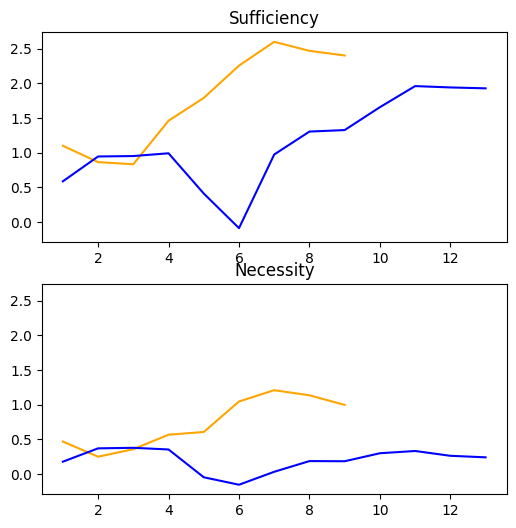

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharey=True)
x = np.arange(1, len(scores1)+1)
x2 = np.arange(1, len(scores2)+1)

# artists = []
# Pair each element of 'test' with the corresponding element of 'test2'
container1 = ax1.plot(x, [a[0] for a in scores1], color="orange")
container2 = ax2.plot(x, [a[1] for a in scores1], color="orange")
container1 = ax1.plot(x2, [a[0] for a in scores2], color="blue")
container2 = ax2.plot(x2, [a[1] for a in scores2], color="blue")
# artists.append(container1 + container2)  # Combine the artists for both subplots in one list

ax1.set_title("Sufficiency")
ax2.set_title("Necessity")


comp = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()
# comp

In [45]:
def get_batch_test(x, tile_ranges_ori, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = shuffle.dinuc_shuffle(x.copy())
        test_batch.append(x_mut)

        ori = x.copy()
        mut = x_mut.copy()
        
        ori, mut = get_swap_greedy(ori, mut, tile_ranges_ori)

        test_batch.append(ori)
        test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)


def get_batch_score_test(pred, trials):

    score = []
    score_sep = []
    for i in range(0, pred.shape[0], 2):
        # print(f"Viewing number {i}")
        score1 = pred[0] - pred[i]
        score2 = pred[i+1] - pred[1]
        score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
        score_sep.append((score1+score2).tolist())
        
    # print(score)
        
    final = np.sum(np.array(score), axis=0)/trials

    #max_ind = np.argmax(final)
    #block_ind = np.argmax(np.array(score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])
    total_score_sep = np.sum(np.array(score_sep), axis=0)/trials

    #print(np.max(score))
    return final, total_score_sep